# Discerning Heatstrokes from COVID-19 the analysis in Japan



## 趣旨

コロナと熱中症は怠惰感、頭痛、高体温などの似通った症状をもっている。そのため、コロナと熱中症は見分けがつきにくいという指摘が度々なされてきた。本レポートは、「気温と強い相関関係のある熱中症」と「気温と正の相関関係を持たないと考えられているコロナ」の特徴を利用することで、コロナの症状が熱中症と誤診される可能性について検討できると考えた。2020年の熱中症の症状数を過去10年間のデータと照らし合わせて分析した結果、緊急搬送時の診断において、コロナの症状が熱中症と十分に見分けがついている、という含意が得られた。

## クエスチョン

緊急搬送の診断において、コロナの患者と熱中症の患者の見分けがついているか

## 実証方法

日本で人口の多い東京、神奈川、大阪の三都道府県を対象にする。2020年をtreatment group、2010年～2019年をcontrol groupとして、気温と熱中症の関係をOLSで測定する。もしコロナを熱中症と数多く誤診しているならば、2010～2019年は気温と熱中症患者数には強い相関関係があるのに対して、2020年は熱中症患者数と気温の相関関係は弱まると考えられる。

## 定義とデータセット

1 熱中症の定義

熱中症患者:医療機関に救急搬送した熱中症又はその疑いのある傷病者の人員（転院搬送による救急搬送事案は除外）

熱中症:「高温環境下で体温の調節機能が破綻するなどして体内の水分や塩分（ナトリウムなど）のバランスが崩れ発症する           障害の総称」であり、日射病、熱けいれん、熱疲労、熱射病等を含むもの
         （詳しくは同ファイル内の「heatstroke_chosa_kaishi.pdf」を参照）


1熱中症のデータ

熱中症総務省消防庁「熱中症による救急搬送人員に関するデータ」
（https://www.fdma.go.jp/disaster/heatstroke/post3.html　）

2 気温のデータ

気象庁、過去の気象データダウンロード
（https://www.data.jma.go.jp/obd/stats/etrn/　）
　気象観測地点は県庁所在地

## 実証結果

2020年においても、2010年～2019年と同様に、緊急搬送時における熱中症患者と気温には十分な相関関係がみられた、つまり、コロナの影響は確認されなかった。よって、コロナを熱中症と誤診されるリスクはこの結果からは検証されなかった。

# 1 Clean Data 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf

In [2]:
pd.options.display.max_rows = 5000 
pd.options.display.max_columns = 1000 

##  Clean temperature data

In [3]:
#気温のデータを読み込む(気温の観測地はそれぞれの県庁所在地（東京、横浜、大阪))

temp_data_tokyo = pd.read_csv("temp_tokyo.csv", encoding="shift-jis")
temp_data_kanagawa = pd.read_csv("temp_kanagawa.csv", encoding="shift-jis")
temp_data_osaka = pd.read_csv("temp_osaka.csv", encoding="shift-jis")


In [4]:
#気温の列名を確認

print(temp_data_tokyo.columns)
print(temp_data_kanagawa.columns)
print(temp_data_osaka.columns)

Index(['ダウンロードした時刻：2020/11/25 18:34:55', 'Unnamed: 1', 'Unnamed: 2',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8'],
      dtype='object')
Index(['ダウンロードした時刻：2020/11/26 12:02:43', 'Unnamed: 1', 'Unnamed: 2',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8'],
      dtype='object')
Index(['ダウンロードした時刻：2020/11/26 12:01:30', 'Unnamed: 1', 'Unnamed: 2',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8'],
      dtype='object')


In [5]:
#無意味な列を落とす

temp_tokyo_drop = temp_data_tokyo.drop(index =range(0,6),columns =['Unnamed: 4', 'Unnamed: 5','Unnamed: 7',
       'Unnamed: 8'])
temp_kanagawa_drop = temp_data_kanagawa.drop(index =range(0,6),columns =['Unnamed: 4', 'Unnamed: 5','Unnamed: 7',
       'Unnamed: 8'])
temp_osaka_drop = temp_data_osaka.drop(index =range(0,6),columns =['Unnamed: 4', 'Unnamed: 5','Unnamed: 7',
       'Unnamed: 8'])

In [6]:
#気温の列名を明確化するために変更

temp_tokyo_rename = temp_tokyo_drop.rename(columns = {'ダウンロードした時刻：2020/11/25 18:34:55':"year",'Unnamed: 1':"month", 
                                                      'Unnamed: 2':"day",'Unnamed: 3':"temp_max",'Unnamed: 6':"temp_mean"})
temp_kanagawa_rename = temp_kanagawa_drop.rename(columns = {'ダウンロードした時刻：2020/11/26 12:02:43':"year",'Unnamed: 1':"month", 
                                                      'Unnamed: 2':"day",'Unnamed: 3':"temp_max",'Unnamed: 6':"temp_mean"})
temp_osaka_rename = temp_osaka_drop.rename(columns = {'ダウンロードした時刻：2020/11/26 12:01:30':"year",'Unnamed: 1':"month", 
                                                      'Unnamed: 2':"day",'Unnamed: 3':"temp_max",'Unnamed: 6':"temp_mean"})

In [7]:
#気温のCSVファイルを全て文字列で読み込んでいるため、整数値（月日）、数値（気温）に変更

temp_tokyo_rename[["year","month","day"]] = temp_tokyo_rename[["year","month","day"]].astype(int) 
temp_tokyo_rename[["temp_max","temp_mean"]] = temp_tokyo_rename[["temp_max","temp_mean"]].astype(float)
temp_kanagawa_rename[["year","month","day"]] = temp_kanagawa_rename[["year","month","day"]].astype(int) 
temp_kanagawa_rename[["temp_max","temp_mean"]] = temp_kanagawa_rename[["temp_max","temp_mean"]].astype(float)
temp_osaka_rename[["year","month","day"]] = temp_osaka_rename[["year","month","day"]].astype(int) 
temp_osaka_rename[["temp_max","temp_mean"]] = temp_osaka_rename[["temp_max","temp_mean"]].astype(float)


In [8]:
#インデックスを一旦日付に変更して一時データを完成

temp_tokyo = temp_tokyo_rename.set_index(["year","month","day"])
temp_kanagawa = temp_kanagawa_rename.set_index(["year","month","day"])
temp_osaka = temp_osaka_rename.set_index(["year","month","day"])

## Clean Heatstroke data

In [9]:
#熱中症のデータを読み込む

heat_data = {} 
for year in range(2010,2021):
    for month in range(6,9):
        heat_data[str(year)+"_0"+str(month)] = pd.read_excel("heatstroke003_data_"+str(year)+".xlsx",sheet_name=str(year)+"_0"+str(month)) 

In [10]:
#６月～８月のデータを連結する

for year in range(2010,2021):
    heat_data[str(year)] = pd.concat([heat_data[str(year)+"_06"],heat_data[str(year)+"_07"],heat_data[str(year)+"_08"]], axis=0, ignore_index=True, join='outer', sort=False)

In [11]:
# 必要な列を抽出

for year in range(2010,2021):
    heat_data[str(year)+"_loc"] = heat_data[str(year)].loc[:,["日付","都道府県コード","搬送人員（計）"]]

In [12]:
#必要な都道府県を抽出(都道府県コード : 13　東京　14　神奈川　27 大阪)

for year in range(2010,2021):
    heat_data[str(year)+"_tokyo"] = heat_data[str(year)+"_loc"].query("都道府県コード == 13") 
    heat_data[str(year)+"_kanagawa"] = heat_data[str(year)+"_loc"].query("都道府県コード==14") 
    heat_data[str(year)+"_osaka"] = heat_data[str(year)+"_loc"].query("都道府県コード==27")

In [13]:
#複数年を連結する

heat_tokyo_append = pd.concat([heat_data["2010_tokyo"],heat_data["2011_tokyo"],heat_data["2012_tokyo"],heat_data["2013_tokyo"],heat_data["2014_tokyo"],heat_data["2015_tokyo"],
                               heat_data["2016_tokyo"],heat_data["2017_tokyo"],heat_data["2018_tokyo"],heat_data["2019_tokyo"],heat_data["2020_tokyo"]],axis = 0)
heat_kanagawa_append = pd.concat([heat_data["2010_kanagawa"],heat_data["2011_kanagawa"],heat_data["2012_kanagawa"],heat_data["2013_kanagawa"],heat_data["2014_kanagawa"],heat_data["2015_kanagawa"],
                               heat_data["2016_kanagawa"],heat_data["2017_kanagawa"],heat_data["2018_kanagawa"],heat_data["2019_kanagawa"],heat_data["2020_kanagawa"]],axis = 0)
heat_osaka_append = pd.concat([heat_data["2010_osaka"],heat_data["2011_osaka"],heat_data["2012_osaka"],heat_data["2013_osaka"],heat_data["2014_osaka"],heat_data["2015_osaka"],
                               heat_data["2016_osaka"],heat_data["2017_osaka"],heat_data["2018_osaka"],heat_data["2019_osaka"],heat_data["2020_osaka"]],axis = 0)

In [14]:
#列名を変更

heat_tokyo_rename = heat_tokyo_append.rename(columns = {'日付':"heat_date",'都道府県コード':"state_num", 
                                                     '搬送人員（計）' : "people",})
heat_kanagawa_rename = heat_kanagawa_append.rename(columns = {'日付':"heat_date",'都道府県コード':"state_num", 
                                                     '搬送人員（計）' : "people",})
heat_osaka_rename = heat_osaka_append.rename(columns = {'日付':"heat_date",'都道府県コード':"state_num", 
                                                     '搬送人員（計）' : "people",})

In [15]:
#データの欠けている行を削除

heat_tokyo_dropna = heat_tokyo_rename.dropna(how = "any", axis = "index")
heat_kanagawa_dropna = heat_kanagawa_rename.dropna(how = "any", axis = "index")
heat_osaka_dropna = heat_osaka_rename.dropna(how = "any", axis = "index")

In [16]:
#インデックスを指定して一時データの完成

heat_tokyo = heat_tokyo_dropna.set_index("heat_date")
heat_kanagawa = heat_kanagawa_dropna.set_index("heat_date")
heat_osaka = heat_osaka_dropna.set_index("heat_date")

In [17]:
# データの欠陥を確認

heat_tokyo.info()
heat_kanagawa.info()
heat_osaka.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2010-06-01 to 2020-08-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state_num  1004 non-null   int64  
 1   people     1004 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 23.5 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2010-06-01 to 2020-08-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state_num  1006 non-null   int64  
 1   people     1006 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 23.6 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1011 entries, 2010-06-01 to 2020-08-31
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state_num  1011 non-null   int64  
 1   people     1011 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 23.

# 2 Make Final Data

### Clean temp data for merging

In [18]:
#各年代の6月～8月の記録を抽出

temp_tokyo_query = temp_tokyo.query("6 <= month <= 8")
temp_kanagawa_query = temp_kanagawa.query("6 <= month <= 8")
temp_osaka_query = temp_osaka.query("6 <= month <= 8")

In [19]:
#欠陥データもなく、計測されていない月日がないことを確認((30+31+31)*11 = 1012)

temp_tokyo_query.info()
temp_kanagawa_query.info()
temp_osaka_query.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1012 entries, (2010, 6, 1) to (2020, 8, 31)
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp_max   1012 non-null   float64
 1   temp_mean  1012 non-null   float64
dtypes: float64(2)
memory usage: 19.4 KB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1012 entries, (2010, 6, 1) to (2020, 8, 31)
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp_max   1012 non-null   float64
 1   temp_mean  1012 non-null   float64
dtypes: float64(2)
memory usage: 19.4 KB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1012 entries, (2010, 6, 1) to (2020, 8, 31)
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp_max   1012 non-null   float64
 1   temp_mean  1012 non-null   float64
dtypes: float64(2)
memory usage: 19.4 KB


In [20]:
# 熱中症のデータが収集されていない日、またはデータ欠陥で削除した日があるのでその日を見つける（東京）

L =[]
def find_missing_date_tokyo(month):
    for year in range(2010,2021):
        for date in range(1,31):
            if date in range(1,10):
                D = str(year) + "0" + str(month) + "0" + str(date)
            else:
                D = str(year) + "0" + str(month)  + str(date)
            if D in  heat_tokyo.index:
                False
            else:
                L.append(D)
    print(L)

find_missing_date_tokyo(6)
find_missing_date_tokyo(7)
find_missing_date_tokyo(8)

['20100614', '20100623', '20110601', '20110602', '20110603', '20140611', '20140612']
['20100614', '20100623', '20110601', '20110602', '20110603', '20140611', '20140612', '20100713']
['20100614', '20100623', '20110601', '20110602', '20110603', '20140611', '20140612', '20100713']


In [21]:
# 熱中症のデータが収集されていない日、またはデータ欠陥で削除した日があるのでその日を見つける（神奈川）

L = []
def find_missing_date_kanagawa(month):
    for year in range(2010,2021):
        for date in range(1,31):
            if date in range(1,10):
                D = str(year) + "0" + str(month) + "0" + str(date)
            else:
                D = str(year) + "0" + str(month)  + str(date)
            if D in heat_kanagawa.index:
                False
            else:
                L.append(D)
    print(L)
find_missing_date_kanagawa(6)
find_missing_date_kanagawa(7)
find_missing_date_kanagawa(8)

['20140606', '20140607', '20140612', '20140622', '20140628']
['20140606', '20140607', '20140612', '20140622', '20140628', '20100712']
['20140606', '20140607', '20140612', '20140622', '20140628', '20100712']


In [22]:
# 熱中症のデータが収集されていない日、またはデータ欠陥で削除した日があるのでその日を見つける（大阪）

L =[]
def find_missing_date_osaka(month):
    for year in range(2010,2021):
        for date in range(1,31):
            if date in range(1,10):
                D = str(year) + "0" + str(month) + "0" + str(date)
            else:
                D = str(year)  + "0" +str(month)  + str(date)
            if D in heat_osaka.index:
                False
            else:
                L.append(D)
    print(L)
find_missing_date_osaka(6)
find_missing_date_osaka(7)
find_missing_date_osaka(8)

[]
['20100712']
['20100712']


In [23]:
#行数を揃えるために気温のデータから上記の日を削除する

temp_tokyo_drop = temp_tokyo_query.drop([(2010,6,14), (2010,6,23), (2011,6,1), (2011,6,2), 
                                   (2011,6,3), (2014,6,11), (2014,6,12), (2010,7,13)],axis = 0)
temp_kanagawa_drop = temp_kanagawa_query.drop([(2014,6,6), (2014,6,7), (2014,6,12), (2014,6,22),
                                         (2014,6,28), (2010,7,12)], axis = 0)
temp_osaka_drop =temp_osaka_query.drop([(2010,7,12)])

In [24]:
#気温のデータのインデックスをリセットする

temp_tokyo_reset = temp_tokyo_drop.reset_index()
temp_kanagawa_reset = temp_kanagawa_drop.reset_index()
temp_osaka_reset = temp_osaka_drop.reset_index()

### Merging temp and heatstroke data

In [25]:
#気温のデータと熱中症のデータを結合する

ht_tokyo = pd.merge(temp_tokyo_reset,heat_tokyo, on = heat_tokyo.index ,how = "right")
ht_kanagawa = pd.merge(temp_kanagawa_reset,heat_kanagawa, on = heat_kanagawa.index ,how = "right")
ht_osaka = pd.merge(temp_osaka_reset,heat_osaka, on = heat_osaka.index ,how = "right")

In [26]:
# treatment group と　control groupに分ける

ht_tokyo_treat = ht_tokyo.query("year == 2020")
ht_tokyo_control =ht_tokyo.query("year != 2020")
ht_kanagawa_treat = ht_kanagawa.query("year == 2020")
ht_kanagawa_control =ht_kanagawa.query("year != 2020")
ht_osaka_treat = ht_osaka.query("year == 2020")
ht_osaka_control =ht_osaka.query("year != 2020")

In [27]:
#都道府県ごとのtreatment group、control groupをそれぞれ結合する

ht_treat = pd.concat([ht_tokyo_treat, ht_kanagawa_treat, ht_osaka_treat], axis = 0)
ht_control = pd.concat([ht_tokyo_control, ht_kanagawa_control, ht_osaka_control], axis = 0)

# 3 Analayze Data

## (a) Summary table

In [28]:
# treatment group(2020年) のsummary table

ht_treat1 = ht_treat.loc[:,[ "temp_max", "temp_mean","people"]]
ht_treat1.agg(['mean', 'std', 'min', 'max', 'count']).T

mean        std   min    max  count
temp_max   30.275362   4.019341  19.7   38.6  276.0
temp_mean  26.130435   3.163361  18.7   32.8  276.0
people     45.489130  61.390167   0.0  363.0  276.0

In [29]:
#control group(2020年)のsummary table

ht_control1 = ht_control.loc[:,[ "temp_max", "temp_mean","people"]]
ht_control1.agg(['mean', 'std', 'min', 'max', 'count']).T

mean        std   min    max   count
temp_max   30.152204   4.010982  17.4   39.0  2745.0
temp_mean  26.047031   3.385241  15.2   33.2  2745.0
people     36.739891  49.580104   0.0  406.0  2745.0

## (b) Scatter plots

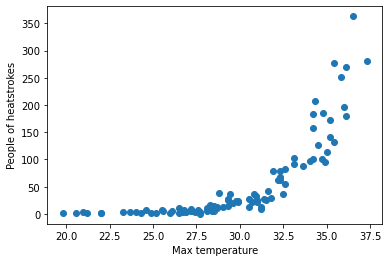

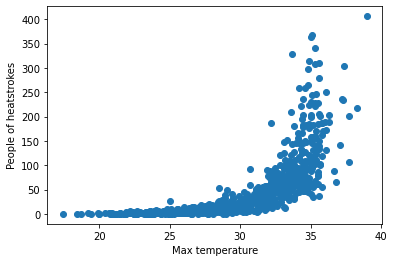

In [30]:
#散布図(東京　上がtreatment, 下がcontrol)

plt.scatter(y=ht_tokyo_treat["people"], x=ht_tokyo_treat['temp_max'])
plt.ylabel("People of heatstrokes")
plt.xlabel("Max temperature")
plt.show()
plt.scatter(y=ht_tokyo_control["people"], x=ht_tokyo_control['temp_max'])
plt.ylabel("People of heatstrokes")
plt.xlabel("Max temperature")
plt.show()

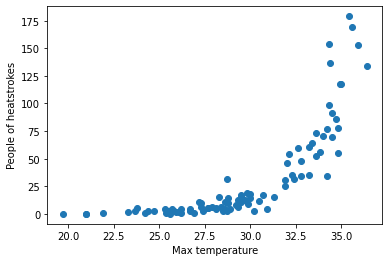

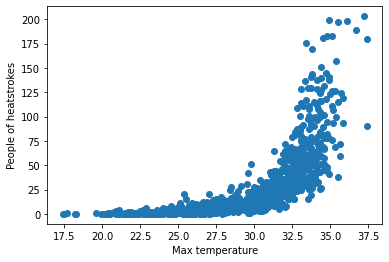

In [31]:
# 散布図(神奈川）

plt.scatter(y=ht_kanagawa_treat["people"], x=ht_kanagawa_treat['temp_max'])
plt.ylabel("People of heatstrokes")
plt.xlabel("Max temperature")
plt.show()
plt.scatter(y=ht_kanagawa_control["people"], x=ht_kanagawa_control['temp_max'])
plt.ylabel("People of heatstrokes")
plt.xlabel("Max temperature")
plt.show()

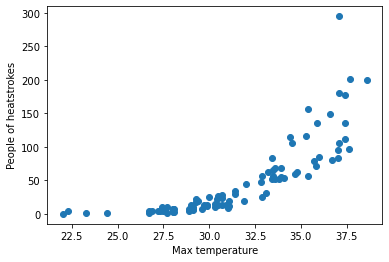

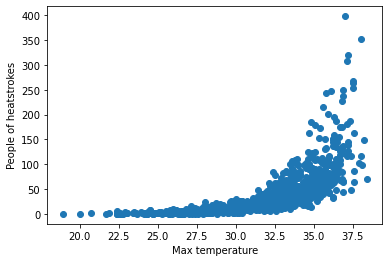

In [32]:
#　散布図（大阪）

plt.scatter(y=ht_osaka_treat["people"], x=ht_osaka_treat['temp_max'])
plt.ylabel("People of heatstrokes")
plt.xlabel("Max temperature")
plt.show()
plt.scatter(y=ht_osaka_control["people"], x=ht_osaka_control['temp_max'])
plt.ylabel("People of heatstrokes")
plt.xlabel("Max temperature")
plt.show()

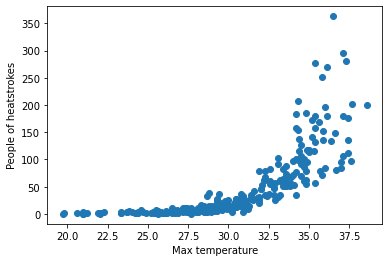

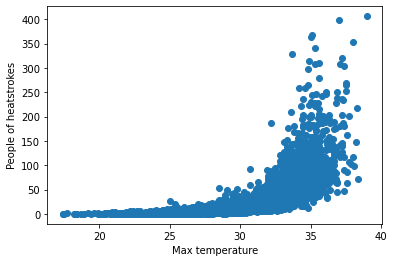

In [33]:
# 散布図（全体）

plt.scatter(y=ht_treat["people"], x=ht_treat['temp_max'])
plt.ylabel("People of heatstrokes")
plt.xlabel("Max temperature")
plt.show()
plt.scatter(y=ht_control["people"], x=ht_control['temp_max'])
plt.ylabel("People of heatstrokes")
plt.xlabel("Max temperature")
plt.show()

## (c) FE

In [34]:
# FE　（東京、神奈川、大阪の地域をダミーにする）

reg1 = smf.ols("people ~ temp_max + C(state_num)" , data=ht_treat).fit()
results_table1 = summary_col(results=[reg1],
                            float_format='%0.3f', 
                            stars=True, 
                            model_names=[ 'FE'], 
                            info_dict={'R-squared' : lambda x: "{:.3f}".format(x.rsquared), 
                                       'Observations' : lambda x: "{0:d}".format(int(x.nobs))},
                            regressor_order=['temp_max'],
                            drop_omitted=True) 
results_table1.add_title("Table 1: Correlation between Heatstrokes and Temperature from June to August in 2020")
print(results_table1)

reg2 = smf.ols("people ~ temp_max + C(state_num)" , data=ht_control).fit()
results_table2 = summary_col(results=[reg2],
                            float_format='%0.3f', 
                            stars=True, 
                            model_names=[ 'FE'], 
                            info_dict={'R-squared' : lambda x: "{:.3f}".format(x.rsquared), 
                                       'Observations' : lambda x: "{0:d}".format(int(x.nobs))},
                            regressor_order=['temp_max'],
                            drop_omitted=True) 
results_table2.add_title("Table 2: Correlation between Heatstrokes and Temperature from June to August in 2010-2019")
print(results_table2)

Table 1: Correlation between Heatstrokes and Temperature from June to August in 2020
                 FE   
----------------------
temp_max     11.875***
             (0.597)  
R-squared    0.604    
Observations 276      
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01
Table 2: Correlation between Heatstrokes and Temperature from June to August in 2010-2019
                FE   
---------------------
temp_max     8.621***
             (0.175) 
R-squared    0.481   
Observations 2745    
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


temp_maxの係数の推定値についてtreatmentの方がcontrolより大きい。よって、2020年においても十分な相関関係をもっている。